3.
$$
A = \left(\begin{matrix}
0.7 & -0.2 & 0.3\\
0.4 & 1.3 & 0.1\\
0.2 & 0.1 & 1.1
\end{matrix}\right), 
f = \left(\begin{matrix}
3\\
1\\
1
\end{matrix}\right)
$$

In [1]:
import numpy as np
from bisect import bisect_left

def MCM(alpha_t, beta, M):
    while True:
        alpha_t = (alpha_t * beta) % M
        yield alpha_t / M

mcm_gen = MCM(79507, 79507, 2**31)

SIZE = 3

A0 = np.array([[0.7, -0.2, 0.3], [0.4, 1.3, 0.1], [0.2, 0.1, 1.1]])
A = -(A0 - np.eye(SIZE))
P = np.full((3, 3), 1 / 3)

f = np.array([3, 1, 1])
pi = np.full(3, 1 / 3)

In [2]:
from tqdm import trange

pi_pref_sums = np.cumsum(pi)
P_pref_sums = np.cumsum(P, axis=1)

NS = np.array([10, 50, 100, 500, 1000])
MS = NS * 10
errors = np.zeros((len(NS), len(MS)))
correct_x = np.linalg.solve(A0, f)

def get_x_ans(N, M):
    x_ans = np.zeros(SIZE)

    for i in trange(SIZE):
        ksi = np.zeros(M)
        for j in range(M):
            Q = np.zeros(N + 1)
            rand_i = bisect_left(pi_pref_sums, next(mcm_gen))
            if pi[rand_i] > 0:
                Q[0] = 1 / pi[rand_i] if rand_i == i else 0

            inds = [rand_i]
            for k in range(1, N + 1):
                prev_i = inds[-1]
                cur_i = bisect_left(P_pref_sums[prev_i], next(mcm_gen))
                if P[prev_i, cur_i] > 0:
                    Q[k] = Q[k - 1] * A[prev_i, cur_i] / P[prev_i, cur_i]
                inds.append(cur_i)

            ksi[j] = Q.dot(f[inds])
        x_ans[i] = np.mean(ksi)
    
    return x_ans

for i_n, N in enumerate(NS):
    for i_m, M in enumerate(MS):
        x_ans = get_x_ans(N, M)
        errors[i_m, i_n] = np.linalg.norm(x_ans - correct_x)

print(errors)

100%|██████████| 3/3 [00:37<00:00, 12.35s/it]

[[0.69525263 0.82001786 0.34876131 0.66071518 1.02229935]
 [0.37778902 0.28976249 0.56971362 0.21656382 0.26794933]
 [0.30022185 0.11063578 0.40909625 0.40705996 0.17834018]
 [0.19438702 0.20713629 0.2188079  0.15285488 0.13958273]
 [0.04362236 0.11777008 0.0602594  0.07313701 0.15798678]]


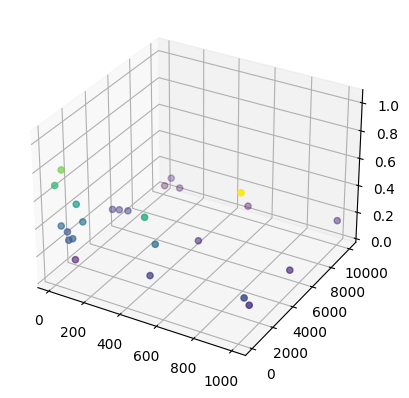

In [3]:
import matplotlib.pyplot as plt

hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

X, Y = np.meshgrid(NS, MS)
ha.scatter(X, Y, errors, c=errors, cmap='viridis')

plt.show()